In [75]:
import multiprocessing
print(f'Using {multiprocessing.cpu_count()} CPUs')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

Using 128 CPUs


/tmp/ipykernel_467360/3957669451.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


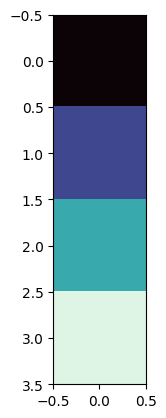

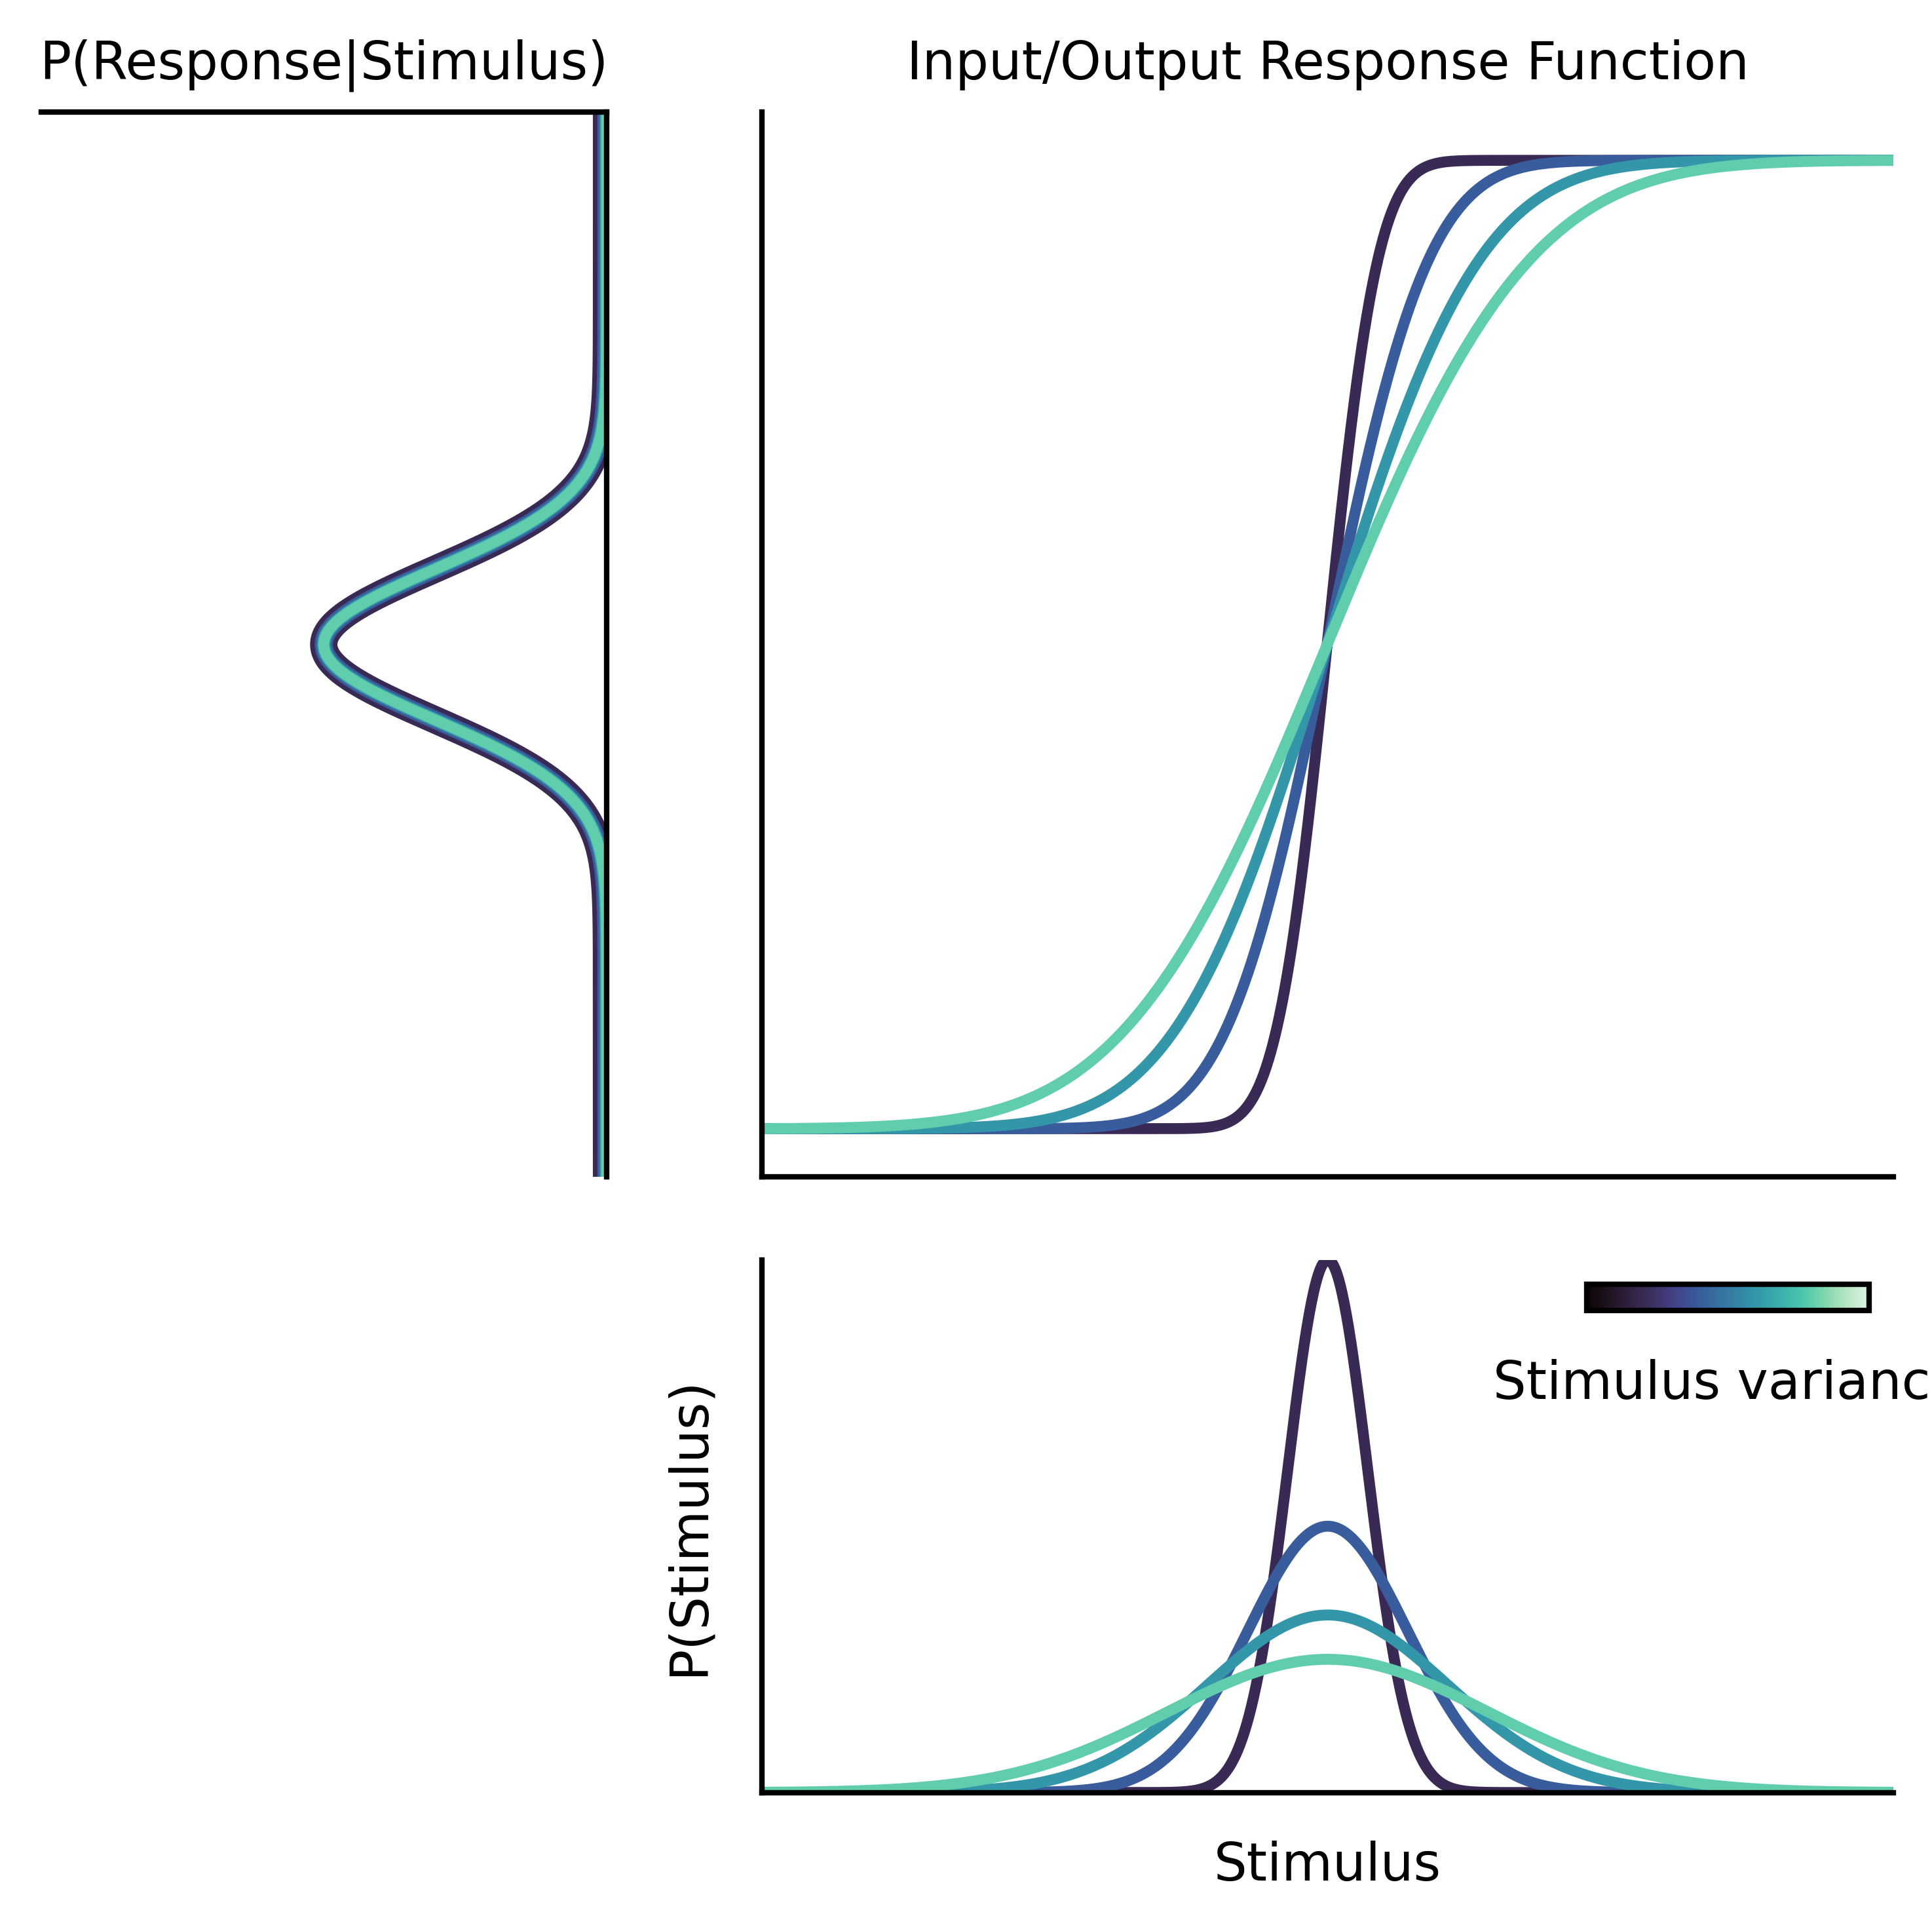

In [89]:
# plot three 1D Gaussians with standard deviations 0.5 1 and 2
def normalize(y):
    return y / np.trapz(y, x)

x = np.linspace(-5, 5, 1000)

s0, s1, s2 = 0.25, 1, 2

s = np.arange(.5, 2.5, .5)
n_stim = len(s)
y = np.array([normalize(np.exp(-x**2 / s0**2) ) for s0 in s])
# cdf of y
c = np.cumsum(y, -1)

cmap = 'mako'
cols = sns.color_palette(cmap, n_stim)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

im = plt.imshow(s[:, None], cmap=cmap)

with sns.plotting_context('paper', font_scale=1.):
    fig, axs = plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[1, 2], 'height_ratios':[2,1]}, sharex='col', figsize=(5, 5),dpi=600)
    for i, (y0, c0) in enumerate(zip(y, c)):
        ystar0 = normalize(y0 * c0)
        ystar0 = normalize(np.exp(-x**2))
        axs[0,0].plot(-ystar0, x, color=cols[i], linewidth=1/(i*.1+.2))
        axs[0,1].plot(x, c0, color=cols[i], linewidth=2,)
        axs[1,1].plot(x, y0, color=cols[i], linewidth=2)

    cbaxes = inset_axes(axs[1,1], width="25%", height="5%", loc='upper right')
    plt.colorbar(im, cax=cbaxes, orientation='horizontal', ticks=[], label='Stimulus variance')

    axs[0,0].set(xticks=[], yticks=[], title='P(Response|Stimulus)', xlim=(-y.max(), 0), ylim=(x.min(), x.max()))
    axs[0,1].set(xticks=[], yticks=[], title='Input/Output Response Function')
    axs[1,1].set(xticks=[], yticks=[], xlabel='Stimulus', ylabel='P(Stimulus)', ylim=(0, y.max()), xlim=(x.min(), x.max()))
    axs[1,0].axis('off')

    sns.despine(ax=axs[0,0], left=True, bottom=True, right=False, top=False)
    sns.despine(ax=axs[0,1])
    sns.despine(ax=axs[1,1])
    fig.tight_layout()

In [77]:
import frame_whitening.simulation as fws
import frame_whitening.plot as fwplt
import frame_whitening as fw

seed = 42069
rng = np.random.default_rng(seed)
theta = 2*rng.uniform(0, np.pi/2)
# print(np.rad2deg(theta))
# theta = np.deg2rad(-10)
sigma_xy = 0.4
C0 = np.array([[1, sigma_xy], 
               [sigma_xy, 1]]) * 2.
Q = fw.rot2(theta)
C = Q @ C0 @ Q.T
# C = C0

batch_size = -1
n_batch = 1024
lr_g = 1E-2
g0 = None
online = False
alpha = 1.
save_every = 1
W_mercedes = fw.get_mercedes_frame()
W_nonneg = np.array([[0, 1, 1], 
                    [1, 1, 0]])
W = W_nonneg
W = fw.normalize_frame(W)
g0 = fws.get_g_opt(W, np.eye(2))

g_last, g_all, errors, _ = fws.adapt_covariance(
    Cxx_list=[C],
    W=W,
    batch_size=batch_size,
    n_batch=n_batch,
    lr_g=lr_g,
    g0=g0,
    online=online,
    clamp=False,
    alpha=1.,
    break_on_convergence=False,
    )


100%|███████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 10756.67it/s]


/tmp/ipykernel_467360/2089869078.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


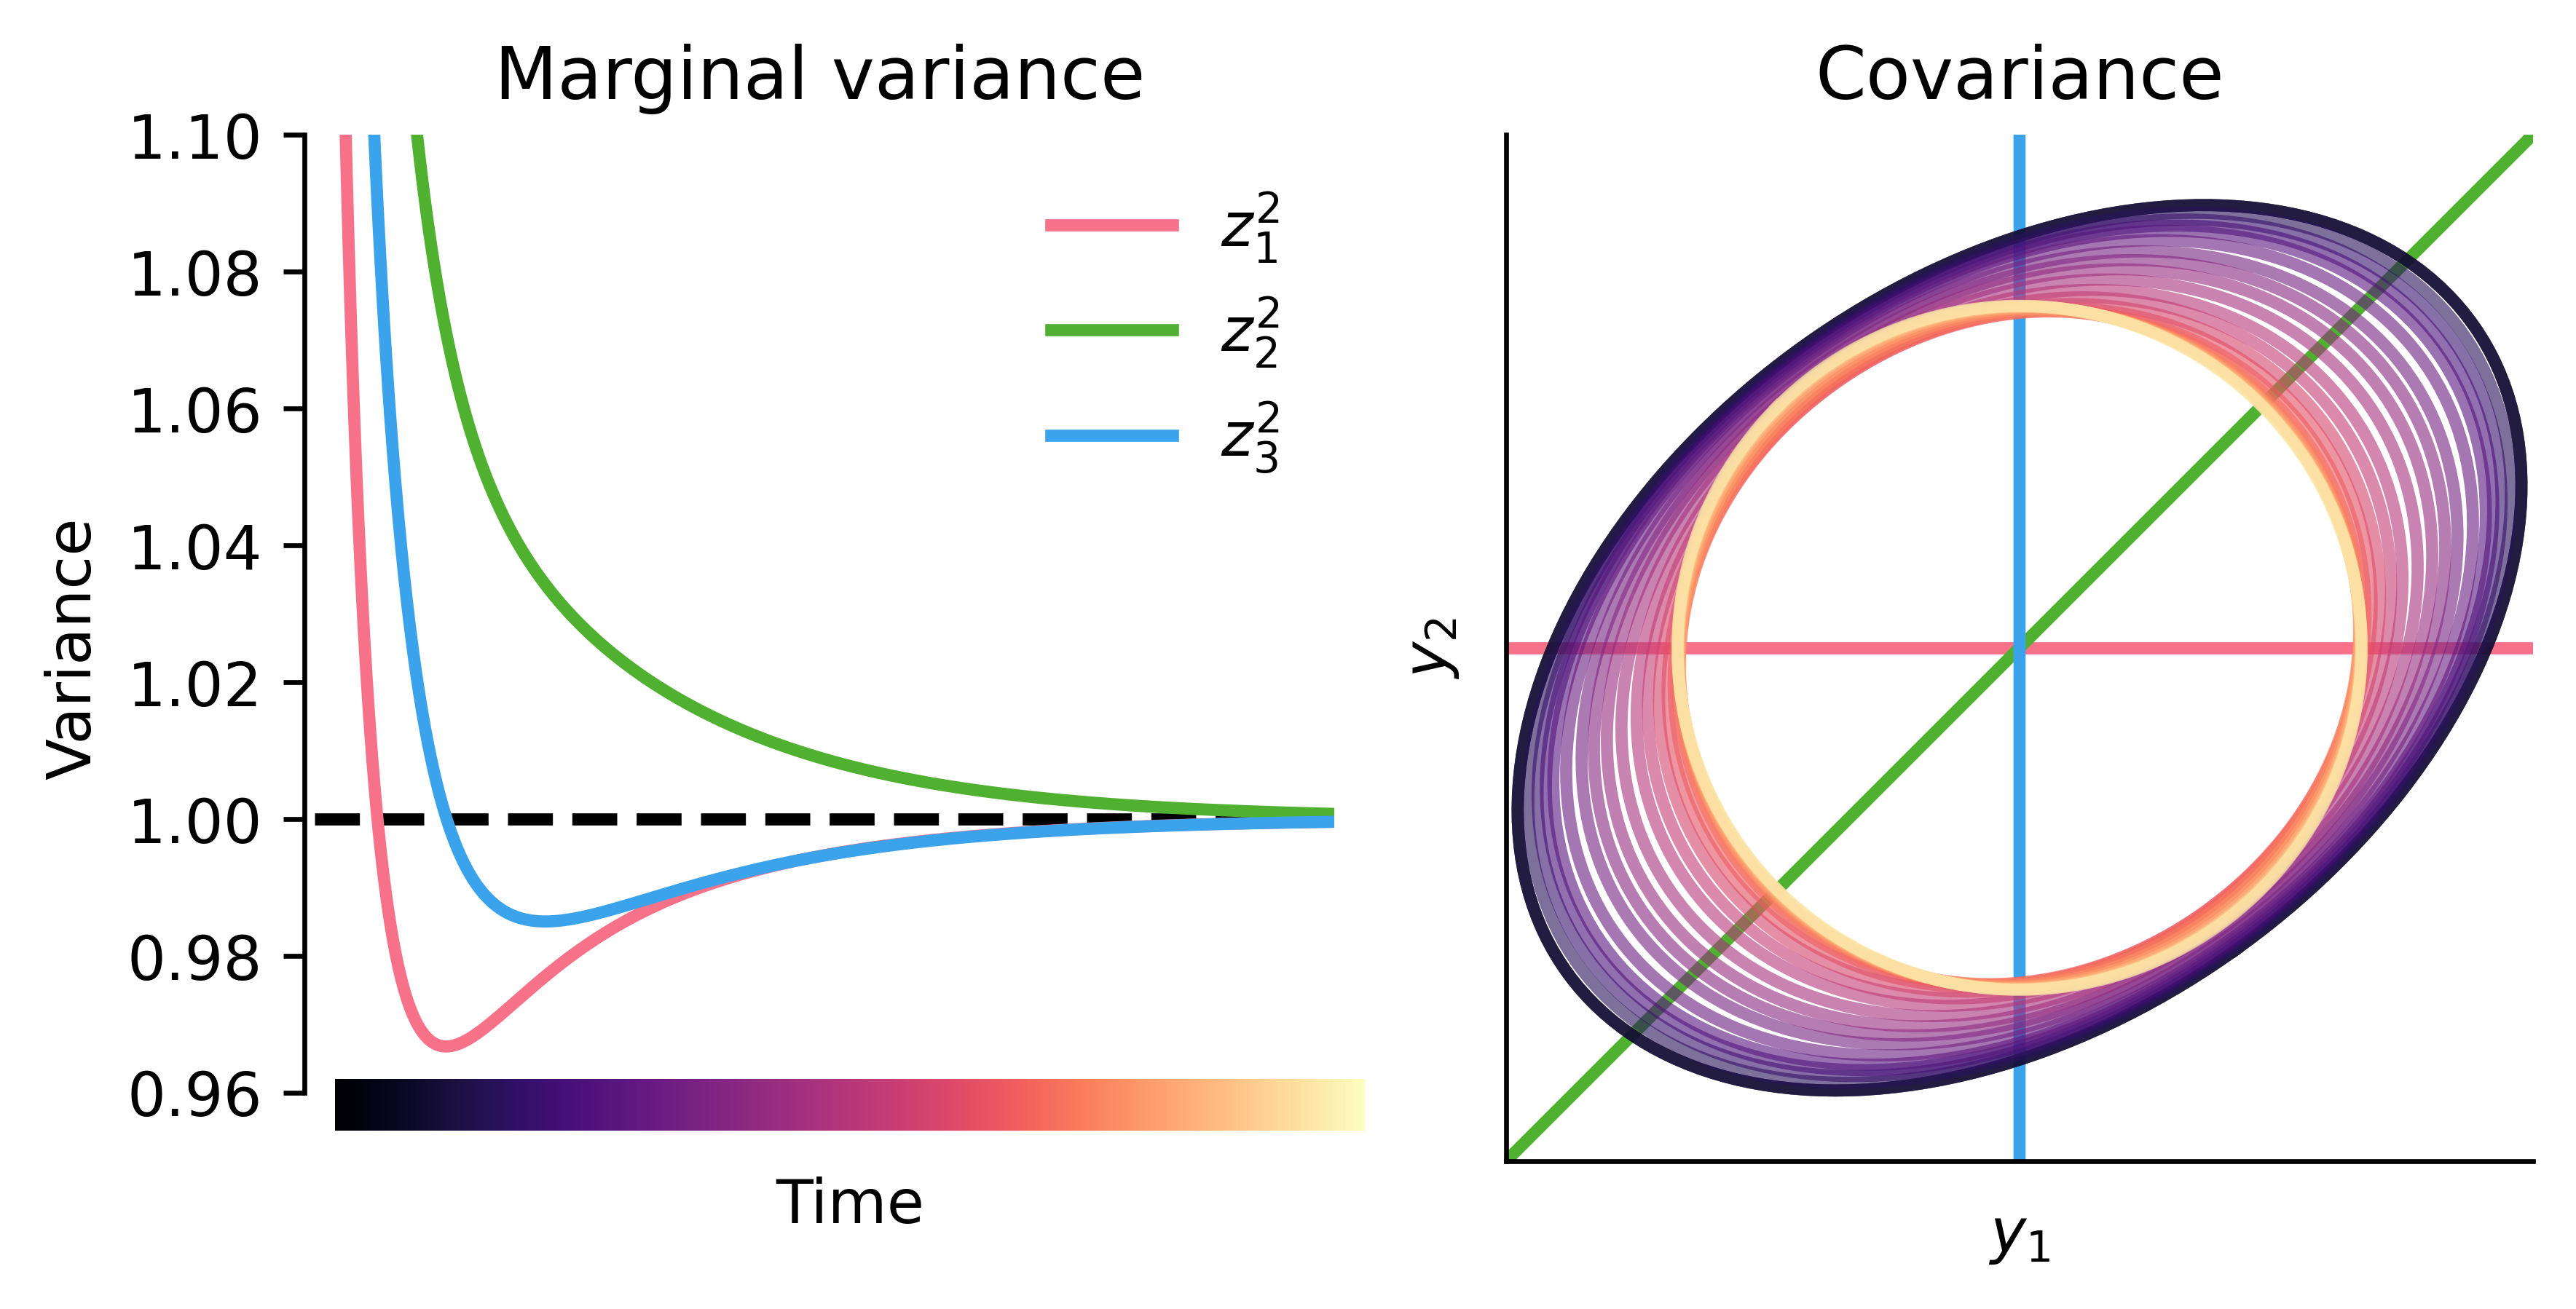

In [90]:
def get_M(g, W):
    N = W.shape[0]
    return np.linalg.inv(np.eye(N) + W @ np.diag(g) @ W.T)

def compute_variances(g, W, Cxx):
    M = get_M(g, W)
    Cyy = M @ Cxx @ M.T
    variances = np.diag(W.T @ Cyy @ W) 
    return variances

step_skip = 2
# log spaced steps 
steps = np.logspace(0, np.log10(len(g_all)), 25, dtype=int)
# to_plot = g_all[:500+step_skip:step_skip]
to_plot = g_all[steps]
n_steps = len(to_plot)

variances = np.array([compute_variances(g, W, C) for g in g_all])
# dummy colorbar
cmap = 'magma'
fig, ax = plt.subplots(1, 1, dpi=0)
im = plt.imshow(np.linspace(0, 1, len(variances))[:, None], cmap=cmap)
plt.close(fig)

cols_frame = sns.color_palette('husl', 3)

fig, ax = plt.subplots(1, 2, dpi=600, figsize=(6, 3), gridspec_kw={'width_ratios':[1, 1]})

# plot marginal variances
with sns.plotting_context('paper'):
    for i in range(3):
        ax[0].plot(variances[:,i], color=cols_frame[i], lw=2, label=f'$z_{i+1}^2$')
cbaxes = inset_axes(ax[0], width="100%", height="5%", loc='lower left')
cb = plt.colorbar(im, cax=cbaxes, orientation='horizontal', ticks=[], label='Time')
cb.outline.set_edgecolor('none')
ax[0].legend(loc='upper right', frameon=False)
ax[0].hlines(1, 0, len(g_all), color='k', lw=2, linestyle='--', zorder=-1)
ax[0].set(xlim=(-10, len(variances)), xticks=[], ylabel='Variance', ylim=(.95, 1.1), title='Marginal variance')
sns.despine(ax=ax[0], bottom=True, trim=True)


# cols_ellipse = sns.color_palette(cmap, int(n_steps*1.2))
cols_ellipse = sns.color_palette(cmap, int(n_steps*1.))
lims = np.array([-3, 3])

# fig, ax = plt.subplots(1, 1)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for i, g in enumerate(to_plot):
    M = get_M(g, W)
    fwplt.plot_ellipse(M@C@M, n_pts=200, color=cols_ellipse[i], alpha=.6, ax=ax[1], lw=2)

# plot axes spanned by frame vectors in W
def plot_frame(W, x, ax, colors, lw=2, ls='--'):
    N = W.shape[1]
    for i in range(N):
        ax.plot(x, W[0,i]/(W[1,i]+eps)*x, color=colors[i], lw=lw, ls=ls, zorder=-1)

lims = np.array((-3., 3.))
x = np.linspace(*(lims*2), 100)
eps = 1E-6
plot_frame(W, x, ax[1], colors=cols_frame, lw=2, ls='-')
# cbaxes = inset_axes(ax, width="25%", height="5%", loc='lower right')
# plt.colorbar(im, cax=cbaxes, orientation='horizontal', ticks=[], label='Time')
ax[1].axis('square')
ax[1].set(xlim=lims, ylim=lims, xticks=[], yticks=[], title='Covariance', ylabel=r'$y_2$', xlabel=r'$y_1$')
# ax[1].axis('off')
sns.despine(ax=ax[1], )
fig.tight_layout()

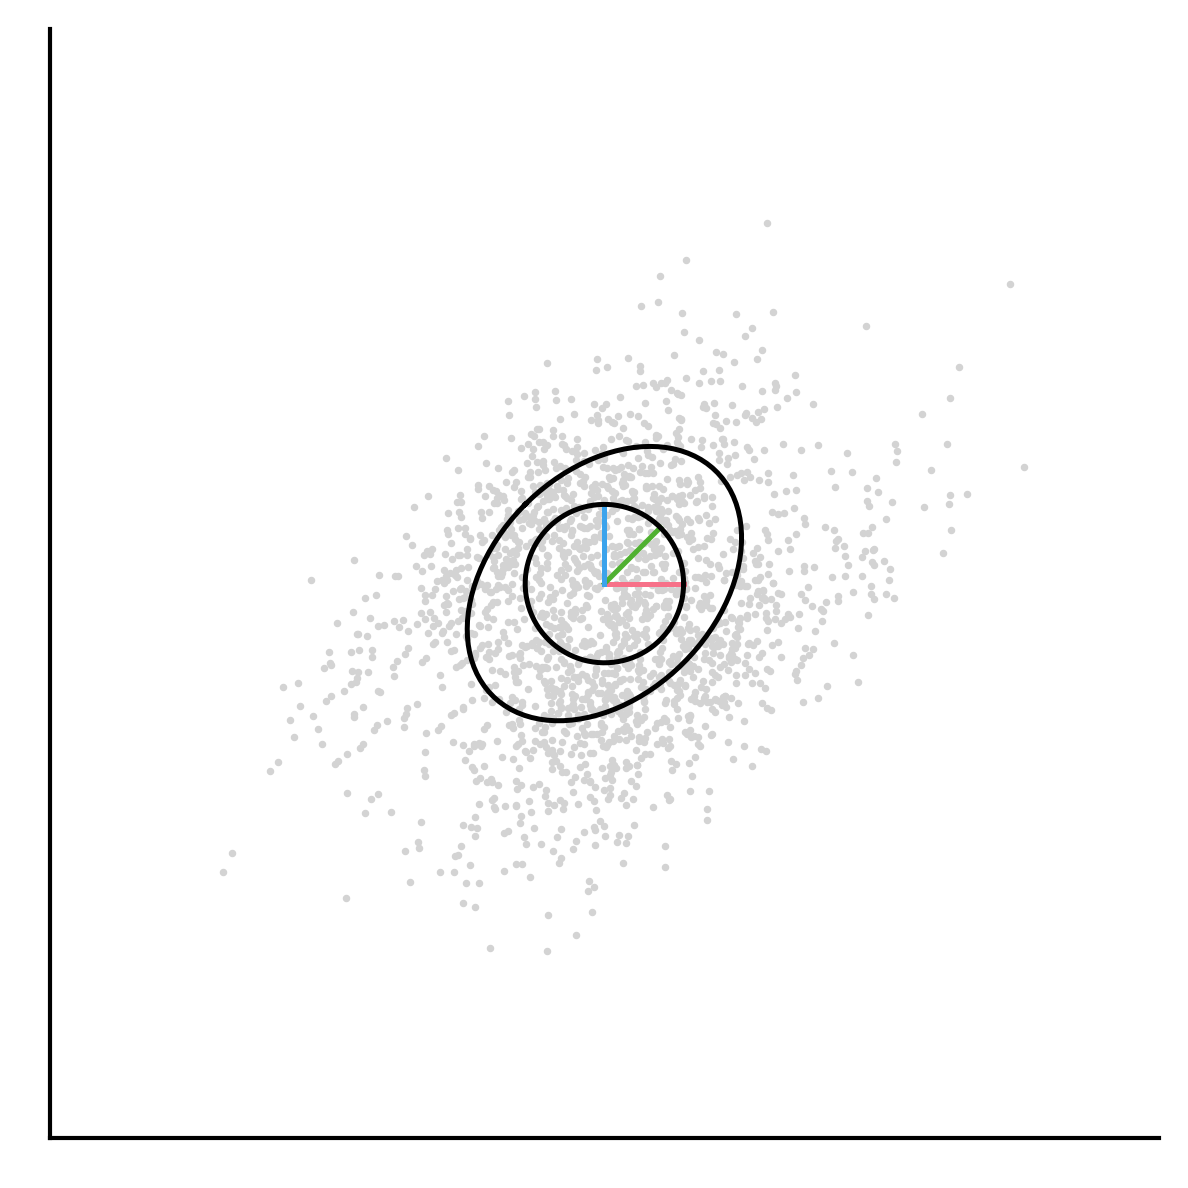

In [79]:
import sklearn.datasets
n_samples = 1000
N = 2
np.random.seed(42069)

X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.28)

X = X - X.mean()

Cxx = np.array([
    [3, 1],
    [1, 3]
])

_, Vx = np.linalg.eigh(Cxx)

Lxx = sp.linalg.sqrtm(Cxx)

tmp = np.linalg.inv(np.cov(X.T))
L12 = np.linalg.cholesky(tmp)

Xw = X @ L12
X0 = Xw @ Lxx
np.cov(X0.T)


F = np.array([[1, 1/np.sqrt(2), 0],
              [0, 1/np.sqrt(2), 1]])

with sns.plotting_context("paper", font_scale=1.5):
  fig, ax = plt.subplots(1, 1, dpi=300, sharex="all", sharey="all")
  ax.scatter(*X0.T, color="lightgrey", s=1)
  ax.axis("square")
  fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax, color="k", stdev=1.)

  cols = sns.color_palette("husl", 3)
  for i, f in enumerate(F.T):
    ax.plot([0, f[0]], [0, f[1]], color=cols[i])

  ax.scatter(*Xw.T, color="lightgrey", s=1)
  fwplt.plot_ellipse(np.eye(2), n_pts=100,  ax=ax, color="k", stdev=1.)
  axlim = 7
  ax.set(xticks=[], yticks=[], xlim=(-axlim,axlim), ylim=(-axlim, axlim))
  sns.despine()

## Frame vs eigenvector decomposition

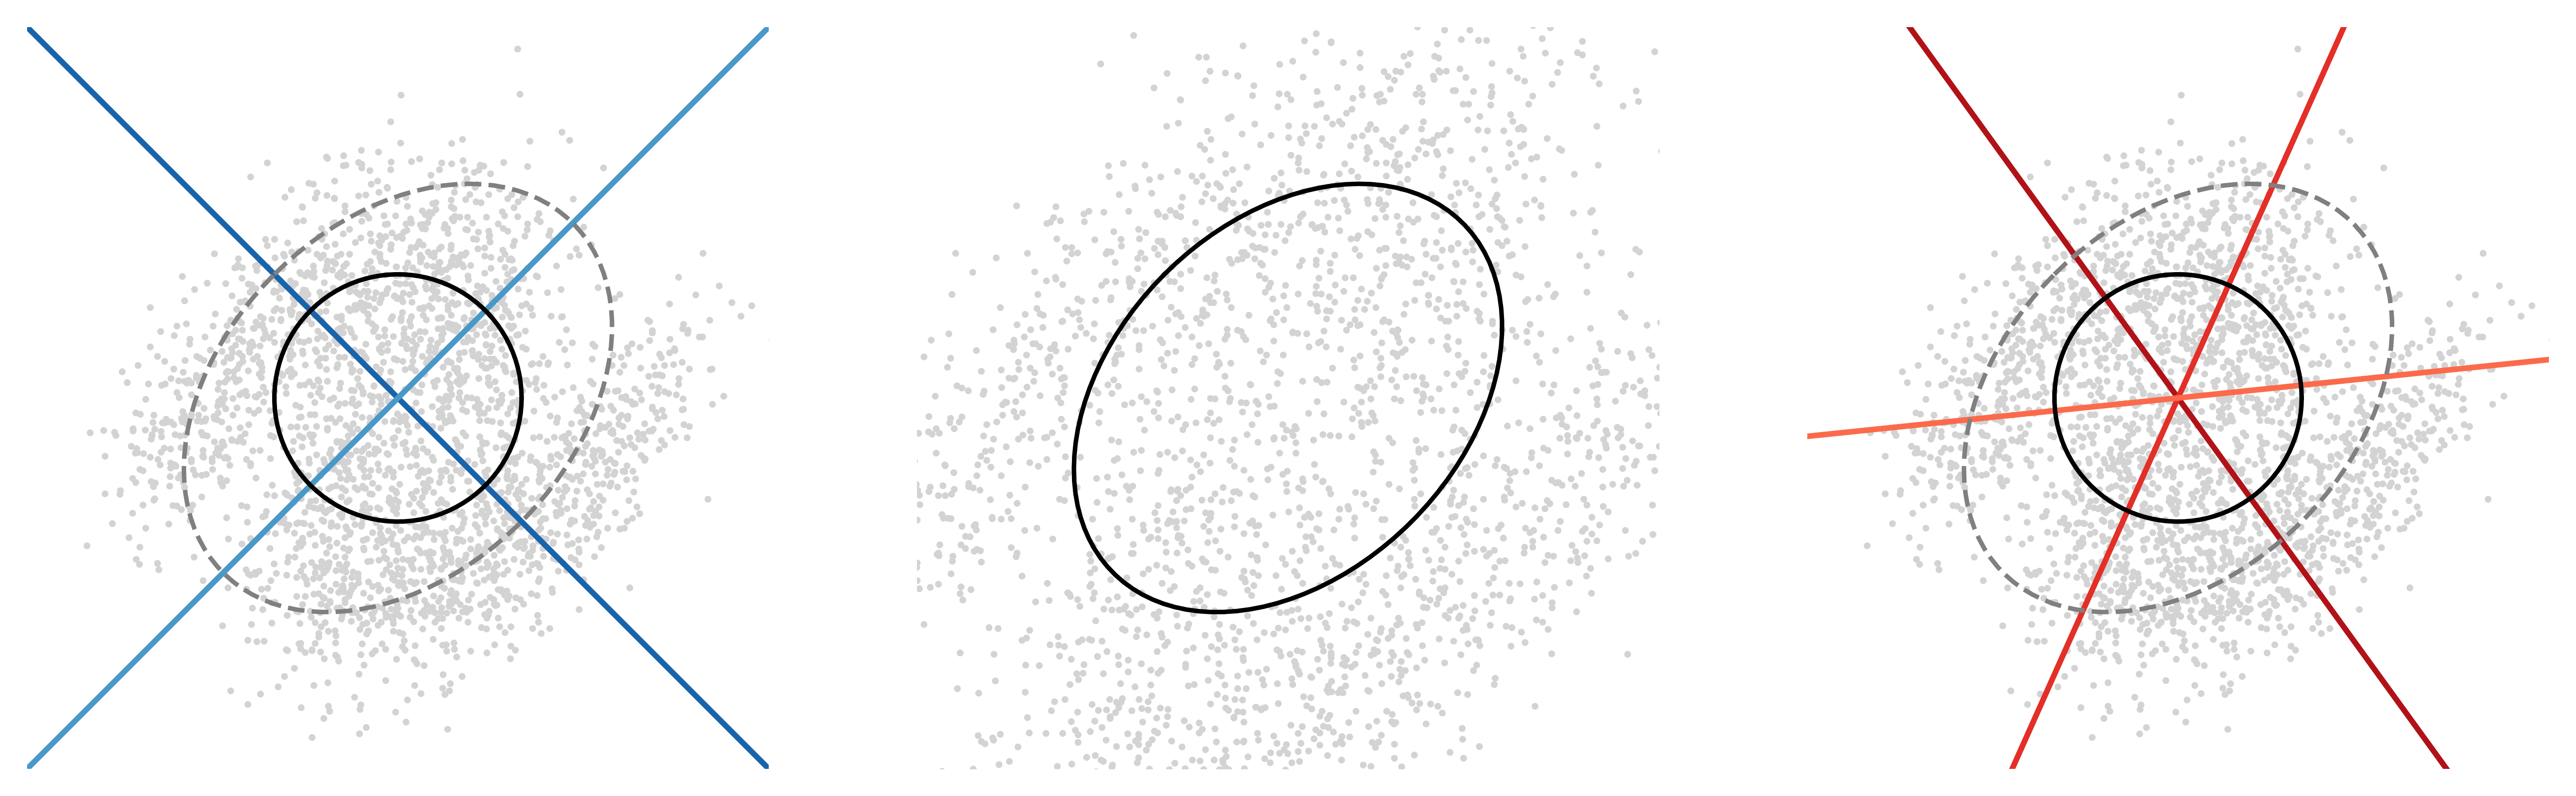

In [88]:
n_samples = 2500
X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.28)

X = X - X.mean(keepdims=True)

Cxx = np.array([
    [3, 1],
    [1, 3]
])

# import scipy.linalg
# Cxx_inv_sqrt = np.linalg.inv(sp.linalg.sqrtm(Cxx))
# Cxx_inv_sqrt = np.concatenate([Cxx_inv_sqrt, np.zeros((1,2))], axis=0)
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(Cxx_inv_sqrt, ax=ax, annot=True, cmap="gray", vmin=-1, vmax=1, cbar=False)

_, Vx = np.linalg.eigh(Cxx)

Lxx = sp.linalg.sqrtm(Cxx)

tmp = np.linalg.inv(np.cov(X.T))
L12 = np.linalg.cholesky(tmp)

Xw = X @ L12
X0 = Xw @ Lxx
np.cov(X0.T)


_, Vxx = np.linalg.eigh(Cxx)
F = np.array([[1, 1/np.sqrt(2), 0],
              [0, 1/np.sqrt(2), 1]])

def plot_axis(ax, lims):
    # plots vertical and horizontal axes
    ax.hlines(0, *lims, color='gray', lw=1, zorder=-1)
    ax.vlines(0, *lims, color='gray', lw=1, zorder=-1)

axlim = 3
lims = np.array((-axlim, axlim))
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=600, sharex="all", sharey="all")
cols_blues = sns.color_palette('Blues_r', 2+2)
cols_reds = sns.color_palette('Reds_r', 3+2)
In = np.eye(2)
stdev = 1.0
lw = 1.5
with sns.plotting_context("paper", font_scale=1.5):
    ax[0].scatter(*Xw.T, color="lightgrey", s=1, zorder=-1)
    ax[0].axis("square")
    fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax[0], color="gray", stdev=stdev, ls='--')
    plot_frame(Vxx, x, ax[0], colors=cols_blues, lw=lw, ls='-')
    fwplt.plot_ellipse(In, n_pts=100, ax=ax[0], color="k", stdev=stdev, ls="-")

    ax[1].scatter(*X0.T, color="lightgrey", s=1, zorder=-1)
    ax[1].axis("square")
    fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax[1], color="k", stdev=stdev)
    ax[1].axis("square")

    rng = np.random.default_rng(42069)
    Q, _ = np.linalg.qr(rng.standard_normal((2, 2)))
    ax[2].scatter(*Xw.T, color="lightgrey", s=1, zorder=-1)
    ax[2].axis("square")
    fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax[2], color="gray", stdev=stdev, ls='--')
    fwplt.plot_ellipse(In, n_pts=100, ax=ax[2], color="k", stdev=stdev, ls="-")
    plot_frame(Q @ W_mercedes, x, ax[2], colors=cols_reds, lw=lw, ls='-')

    ax[0].set(xticks=[], yticks=[], xlim=(-axlim,axlim), ylim=(-axlim, axlim),
    #   title='Eigenvector decomposition'
    )
    #   ax[1].set(title=r'Inputs with $N\times N$ covariance')
    #   ax[2].set(title='Frame decomposition')
    sns.despine(bottom=True, left=True)
    fig.tight_layout